
<h1> Creation of ARIMA model on the total data recorded by ISTAT </h1>


<p> The DataFrame used contains the data relating to the total daily deaths recorded by ISTAT from <b> 1 January 2015 </b> to <b> 30 April 2020 </b>.
    </p>

In [1]:
import pandas as pd
df = pd.read_csv('../csv/deaths_tot.csv')
df.head()

Data  Totale
0  2015-01-01    2632
1  2015-01-02    2182
2  2015-01-03    2215
3  2015-01-04    2264
4  2015-01-05    2301

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    1947 non-null   object
 1   Totale  1947 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.5+ KB


In [3]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1947 non-null   datetime64[ns]
 1   Totale  1947 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.5 KB


<h2> Creations of the time series </h2>

In [4]:
df=df.set_index('Data')
ts = df.Totale
ts.head()

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
Name: Totale, dtype: int64

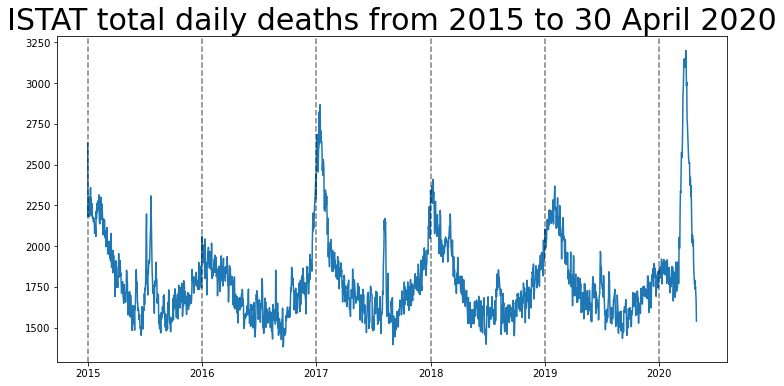

In [5]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('ISTAT total daily deaths from 2015 to 30 April 2020', size=30)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposition


Using the `seasonal_decompose ()` function, the time series is decomposed into <b> trends </b>, <b> seasonality </b> and <b> residuals </b>.

Through this process it is possible to view in more detail the trend of the historical series examined, with the aim of using the information acquired for the creation of a valid predictive model.


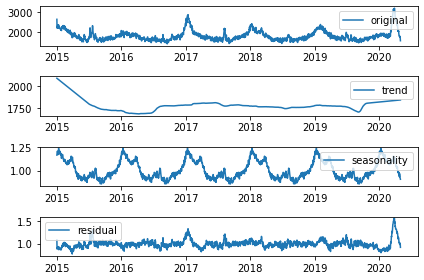

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend 
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2>
Stationary test

The modeling of a time series is only possible if the series is <b> stationary </b>, i.e. when its statistical properties do not vary over time.

The `test_stationarity ()` function checks whether the time series is stationary or not by calculating the <b> Rolling Statistic </b> and the <b> Dickey-Fuller test </b>.

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

In [8]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -6.969065e+00
p-value                        8.760107e-10
#Lags Used                     0.000000e+00
Number of Observations Used    1.946000e+03
Critical Value (1%)           -3.433715e+00
Critical Value (5%)           -2.863026e+00
Critical Value (10%)          -2.567561e+00
dtype: float64
X is stationary



<H2> Autocorrelation and Partial Autocorrelation

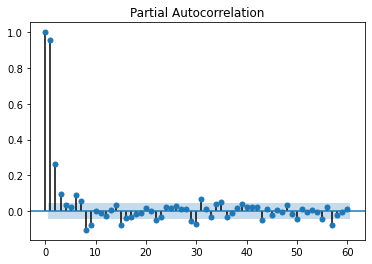

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =60)
plot_pacf(ts, lags =60)
plt.show()


<h2> Subdivision of the time series into train and test

In order to build a predictive model it is necessary to divide the <b> time series </b> into `train` and` test`.
<br />
The part of `train`, which runs from <b> January 1, 2015 </b> to <b> October 31, 2019 </b>, will be used for training the model.
<br />
The part of `test`, which runs from <b> November 1st 2019 </b> to <b> December 31st 2019 </b>, will be used instead to test the prediction accuracy of the model created, comparing the prediction obtained with the original values ​​of the `test` part.

In [12]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

# period from 01-01-2015 to 31-10-2019
train = ts[:train_end]

# period from 01-11-2019 to 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]


<h1> CREATION OF THE MODEL

In [13]:
from statsmodels.tsa.arima_model import ARIMA
p = 1
q = 8
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequ

                              ARMA Model Results                              
Dep. Variable:                 Totale   No. Observations:                 1765
Model:                     ARMA(1, 8)   Log Likelihood              -10015.881
Method:                       css-mle   S.D. of innovations             70.457
Date:                Wed, 23 Dec 2020   AIC                          20053.762
Time:                        15:59:17   BIC                          20113.997
Sample:                    01-01-2015   HQIC                         20076.019
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1790.6616     70.429     25.425      0.000    1652.624    1928.700
ar.L1.Totale     0.9881      0.004    225.555      0.000       0.980       0.997
ma.L1.Totale    -0.3494      0.025    -14.25


<h2> Verify that the model residuals are stationary

In [15]:
residuals = model_fit.resid
test_stationarity(residuals)

Results of Dickey-Fuller Test:
Test Statistic                  -45.111192
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


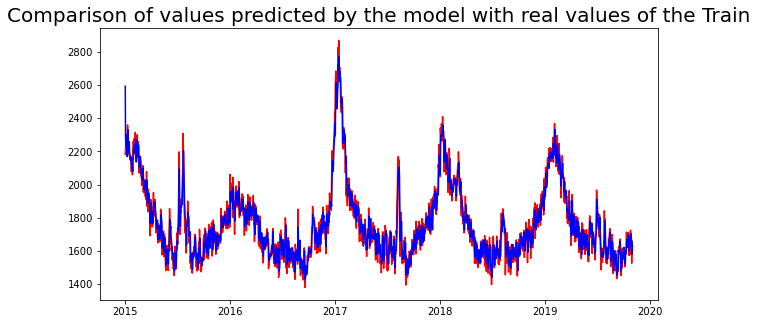

In [17]:
plt.figure(figsize=(10,5))
plt.title('Comparison of values predicted by the model with real values of the Train', size=20)
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()


<h2> Confidence interval of the model

In [20]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.title('Confidence interval of the model', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()


<h2> Prediction of the model on the test

In [21]:
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-01 00:00:00


In [22]:
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10,5))
plt.title('Prediction of the model on the test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test.iloc[1:], label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [23]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.3193306805770519


<h1> Total prediction

In [24]:
start = ts.index[0]
end = ts.index[-1]


print(end)
print(start)

2020-04-30 00:00:00
2015-01-01 00:00:00


In [25]:
predictions_tot = model_fit.predict(start=start, end=end)

plt.figure(figsize=(12,6))
plt.title('Total prediction until 30 April 2020', size=20)
plt.plot(ts, color='red', label='actual')
plt.plot(predictions_tot.iloc[1:], label='prediction', color='blue')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

In [26]:
predictions_tot

2015-01-01    1790.661623
2015-01-02    2591.478055
2015-01-03    2292.515915
2015-01-04    2233.222115
2015-01-05    2256.919914
                 ...     
2020-04-26    1769.548586
2020-04-27    1769.799571
2020-04-28    1770.047572
2020-04-29    1770.292626
2020-04-30    1770.534766
Freq: D, Length: 1947, dtype: float64

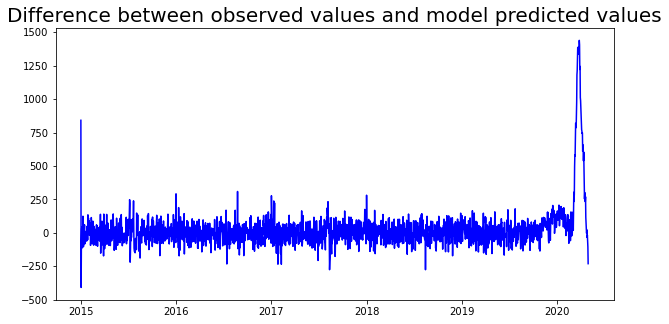

In [27]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Difference between observed values and model predicted values', size=20)
plt.plot(diff_predictions_tot, color='blue') 
plt.show()

In [28]:
predictions_tot.to_csv('../csv/predictions_daily_ARIMA.csv')

In [29]:
diff_predictions_tot

Data
2015-01-01    841.338377
2015-01-02   -409.478055
2015-01-03    -77.515915
2015-01-04     30.777885
2015-01-05     44.080086
                 ...    
2020-04-26    -34.548586
2020-04-27    -17.799571
2020-04-28    -68.047572
2020-04-29   -106.292626
2020-04-30   -231.534766
Length: 1947, dtype: float64

In [30]:
diff_predictions_tot['24-02-2020':].sum()

38241.594360144016